In [3]:
! pip install mne numpy scipy matplotlib tensorflow skfeature-chappers seaborn

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import mne
import warnings
import numpy as np
from importlib import reload
from Functions import Data_path, Plot_data, Filtering, FFT, Common_average_reference, PSDA_a_trial, PSDA, CCA, ROC
from Functions import FoCCA, FBCCA, MSI, FFT_Feature_Extraction, Plot_features, CCA_Feature_Extraction
from Functions import Feature_selections, Knn_optimal

import sys

np.set_printoptions(threshold=sys.maxsize)


In [5]:
# Define the base folder path where the data is located
folder_path = "/home/ubie/Desktop/Telekinesis/classify/Data" 
path_files, files, folders = Data_path.data_path(folder_path, data_format="gdf") 
path_files

['/home/ubie/Desktop/Telekinesis/classify/Data/Subject2-[2012.04.07-19.27.02].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject2-[2012.04.07-19.36.29].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject2-[2012.04.07-19.44.23].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject2-[2012.04.07-19.57.52].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject3-[2012.04.07-18.17.50].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject3-[2012.04.07-18.27.18].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject3-[2012.04.07-18.45.34].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject3-[2012.04.07-18.53.10].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject4-[2012.04.08-16.06.48].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject4-[2012.04.08-16.19.25].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject4-[2012.04.08-16.27.27].gdf',
 '/home/ubie/Desktop/Telekinesis/classify/Data/Subject4-[2012.04.08-16.35.27

In [6]:
time_trial = 5                          # Define the duration of each trial in seconds
data1, data2, data3 = [], [], []
lab = ['33025', '33026', '33027']       # Define the labels for the current iteration
data_list = [data1, data2, data3]       # Initialize a list to store data lists
warnings.filterwarnings("ignore", message="Omitted .* annotation.*")

for i in range(len(path_files)):
    raw = mne.io.read_raw_gdf(path_files[i], verbose=0)# Read the data from the GDF file into a raw MNE object
    fs = raw.info['sfreq']                             # Get the sampling frequency of the EEG data
    channels_name = raw.ch_names                       # Extract the channel names from the raw data
    # Calculate the duration of each trial in samples based on the sampling frequency (Fs * time each trial)
    duration_trial = int(fs * time_trial)   
    # Get the EEG data and transpose it to have channels as rows and samples as columns
    data = 10**6 * raw.get_data().T
    labels = raw.annotations.description                # Define labels for each stimulation frequency
    # Get the start time of each trial from the annotations
    events, _ = mne.events_from_annotations(raw, verbose=0) 
    time_start_trial = events[:, 0]                     # Extract the start time of each trial from the events 
    
    for j, val in enumerate(lab):                                  # Loop through the labels of interest
        num_trials = np.where(labels == val)[0]      # Find the indices of trials with the current label
        # Initialize an array to store trial data for the current label
        data_trial = np.zeros((duration_trial, len(channels_name), len(num_trials)))
        
        # Iterate over each trial index and extract the corresponding data
        for ind, trial_index in enumerate(num_trials):  
            data_trial[:, :, ind] = data[time_start_trial[trial_index]:time_start_trial[trial_index] + 
                                         duration_trial, :]
        
        # Append data_trial to the corresponding list based on the value of j
        data_list[j].append(data_trial)
        
# Concatenate the lists of data arrays along the third axis
data1 = np.concatenate(data1, axis=2)
data2 = np.concatenate(data2, axis=2)
data3 = np.concatenate(data3, axis=2)

np.save('trials/13hz.npy', data1)
np.save('trials/21hz.npy', data2)
np.save('trials/17hz.npy', data3)

print(f"data1.shape: {data1.shape} \ndata2.shape: {data2.shape} \ndata3.shape: {data3.shape}")
print(labels)

data1.shape: (1280, 8, 160) 
data2.shape: (1280, 8, 160) 
data3.shape: (1280, 8, 160)
['32769' '33024' '32779' '32780' '33026' '32779' '32780' '33027' '32779'
 '32780' '33025' '32779' '32780' '33026' '32779' '32780' '33025' '32779'
 '32780' '33024' '32779' '32780' '33027' '32779' '32780' '33025' '32779'
 '32780' '33026' '32779' '32780' '33027' '32779' '32780' '33024' '32779'
 '32780' '33026' '32779' '32780' '33024' '32779' '32780' '33027' '32779'
 '32780' '33025' '32779' '32780' '33024' '32779' '32780' '33027' '32779'
 '32780' '33025' '32779' '32780' '33026' '32779' '32780' '33027' '32779'
 '32780' '33024' '32779' '32780' '33025' '32779' '32780' '33026' '32779'
 '32780' '33025' '32779' '32780' '33027' '32779' '32780' '33026' '32779'
 '32780' '33024' '32779' '32780' '33027' '32779' '32780' '33026' '32779'
 '32780' '33024' '32779' '32780' '33025' '32779' '32780' '33024' '32779'
 '32780' '33026' '32779' '32780' '33027' '32779' '32780' '33025' '32779'
 '32780' '33024' '32779' '32780' '3302

(480, 6)
[[1.63111928e-02 3.90348383e-03 4.08635162e-04 9.60478556e-05
  3.56019057e-03 1.22040718e-03]
 [9.61505456e-02 5.75495483e-03 6.23810904e-04 8.63511589e-05
  1.41923683e-03 2.90464512e-04]
 [6.94545196e-02 8.09659533e-03 2.33746226e-03 2.36153775e-05
  4.26939065e-03 1.50569241e-03]
 [3.93680296e-02 1.67478726e-02 2.02695797e-03 3.02807336e-04
  2.18779382e-03 1.51750340e-03]
 [2.88439115e-02 1.97729587e-03 1.49248054e-03 2.40346310e-05
  4.85999133e-03 2.66465247e-04]
 [3.16093653e-02 2.13039805e-04 1.83368437e-03 3.35788387e-04
  5.23751513e-03 7.32271908e-04]
 [5.71189210e-02 2.25395668e-03 1.02517868e-03 3.33915091e-04
  2.92348324e-03 2.25909907e-04]
 [1.03662604e-02 3.15949209e-03 8.68713880e-04 3.10224868e-05
  9.68001432e-04 3.01718682e-04]
 [4.15977028e-02 4.44943247e-03 7.36579304e-04 3.88043748e-04
  4.92384745e-03 7.31610143e-04]
 [5.34187189e-02 2.80133602e-03 2.44016268e-03 6.28148945e-04
  3.71772329e-03 4.04570042e-04]
 [1.20128190e-01 2.27751041e-03 4.2330009

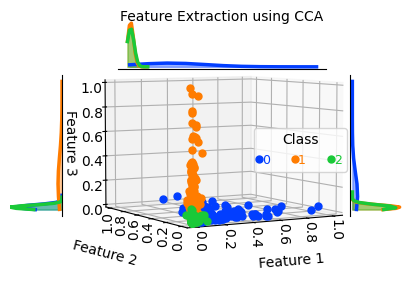

In [7]:
# ----------------------------------- Step 1: Combine all of datasets ----------------------------------------
data_total = np.concatenate((data1, data2, data3), axis=2)
labels = np.concatenate((np.full(data1.shape[-1], 0), np.full(data2.shape[-1], 1), np.full(data3.shape[-1], 2)))    # predicted results
# -------------------------------- Step 2: Filtering for all of datasets -------------------------------------
order = 4                # Define filter order
notch_freq = 50          # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20      # Define quality factor for the notch filter
subbands = [[12, 16, 20],
            [14, 18, 22]]
f_low = np.min(subbands) - 1  # Define lower cutoff frequency for the bandpass filter (Hz)
f_high = np.max(subbands) + 1 # Define upper cutoff frequency for the bandpass filter (Hz)
notch_filter = "on"       # on or off
filter_active = "on"      # on or off
type_filter = "bandpass"  # low, high, bandpass, or bandstop
# Apply notch filter to the EEG data using the Filtering.filtering function
filtered_data = Filtering.filtering(data_total, f_low, f_high, order, fs, notch_freq, quality_factor, 
                                    filter_active, notch_filter, type_filter)
# ------------------------------------- Step 3: CAR for all of datasets --------------------------------------
data_car = Common_average_reference.car(filtered_data) 
# ---------------------------------- Step 4: Feature Extraction using CCA ------------------------------------
num_harmonic = 4          # Number of harmonic for each frequency stimulation
f_stim = [13, 21, 17]     # Frequencies stimulation
num_channel = [0, 1]      # Number of Channel     
title = f"Feature Extraction using CCA"

# Perform cca_feature_extraction analysis for multiple channels
features_extraction = CCA_Feature_Extraction.cca_feature_extraction(data_car, fs, f_stim, num_channel, num_harmonic)

print(features_extraction.shape)
print(features_extraction)


Plot_features.plot_features(features_extraction, labels, title, location_legend=5)


(480, 6)


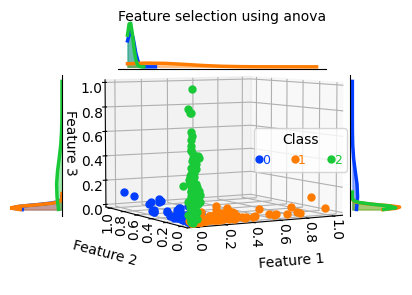

In [8]:
num_features = 24
n_neighbors_MI = 5                 # Number of neighbors to consider for mutual information calculation.
L1_Parameter = 0.2                 # Parameter value for L1 regularization.
threshold_var = 0.001              # The threshold used for variance thresholding.
type_feature_selection = "anova"   # var, anova, mi, ufs, rfe, rf, l1fs, tfs, fs, ffs, bfs
title = f"Feature selection using {type_feature_selection}"

features = Feature_selections.feature_selecions(features_extraction, labels, num_features,threshold_var,
                                                         n_neighbors_MI, L1_Parameter, type_feature_selection)

print(features.shape)
Plot_features.plot_features(features, labels, title, location_legend=5, fig_size=(4, 3))

In [9]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import model_selection, metrics, neural_network, tree, naive_bayes, discriminant_analysis, neighbors
from sklearn import preprocessing, svm, ensemble, linear_model
from tensorflow.keras.utils import to_categorical  # Convert labels to categorical (one-hot encoding)
import tensorflow as tf
from tensorflow import keras
from Functions import ROC

2024-11-21 01:15:13.498362: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 01:15:13.499328: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 01:15:13.501836: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 01:15:13.506365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732131913.516624   91865 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732131913.51

In [10]:
# ================================================== Data normalization ==================================================
def data_normalization(x_train, x_test, method="MinMaxScaler"):    
    if x_train.ndim == 1:
        x_train = x_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
        
    if method == "MinMaxScaler":
        norm = preprocessing.MinMaxScaler()
    elif method == "StandardScaler":
        norm = preprocessing.StandardScaler()
        
    x_train = norm.fit_transform(x_train)
    x_test = norm.transform(x_test)
    
    return x_train, x_test

# ================================================ Plot_classification =================================================== 
def plot_classification(data_train, label_train, data_test, label_test, model, k_fold, type_class, display_classification="off", display_normalize_classification="on", fig_size_classification=(5, 3)):
    # --------------------------------------------------- Data transpose -------------------------------------------------
    if display_classification == "on":
        if data_train.shape[0] < data_train.shape[1]:
            data_train = data_train.T
    
        if data_test.shape[0] < data_test.shape[1]:
            data_test = data_test.T   
        # ------------------------------------------ Predict the train & test labels -------------------------------------
        miss_class_train = label_train - model.predict(data_train)      # predict the train labels
        miss_class_train = len(miss_class_train[miss_class_train != 0])
        
        miss_class_test = label_test - model.predict(data_test)         # predict the test labels
        miss_class_test = len(miss_class_test[miss_class_test != 0]) 
        lab = np.unique(label_train)
        # ------------------------------------------------- Data normalization -------------------------------------------
        if display_normalize_classification=="on":
            if np.max(data_train) > 1:
                norm = preprocessing.MinMaxScaler()
                data_train = norm.fit_transform(data_train)
                data_test = norm.fit_transform(data_test)
        # --------------------------------------------------- Plot -------------------------------------------------------
        if data_train.shape[1] < 3:
   
            resolution = 0.03
            x_combined = np.vstack((data_train, data_test))
            y_combined = np.hstack((label_train, label_test))
            x1_min, x1_max = x_combined[:, 0].min() - 1, x_combined[:, 0].max() + 1
            x2_min, x2_max = x_combined[:, 1].min() - 1, x_combined[:, 1].max() + 1
            xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
            z = model.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
            
            fig, axs = plt.subplots(1, 2, sharey='row', figsize=fig_size_classification, constrained_layout=True)
            colors = list(reversed(sns.color_palette("bright", len(lab)).as_hex()))
            cmp = ListedColormap(colors[:len(lab)])
            
            axs[0].contourf(xx1, xx2, z.reshape(xx1.shape), alpha=0.2, cmap=cmp)
            axs[0].set_xlim(xx1.min(), xx1.max())
            axs[0].set_ylim(xx2.min(), xx2.max())

            axs[1].contourf(xx1, xx2, z.reshape(xx1.shape), alpha=0.2, cmap=cmp)
            axs[1].set_xlim(xx1.min(), xx1.max())
            axs[1].set_ylim(xx2.min(), xx2.max())

            for i in range(0, len(np.unique(y_combined))):
                axs[0].plot(data_train[label_train==lab[i], 0], data_train[label_train==lab[i], 1], '.', color=colors[i], label=lab[i], markersize=10)
                axs[1].plot(data_test[label_test==lab[i], 0], data_test[label_test==lab[i], 1], '.', color=colors[i], label=lab[i], markersize=10)
            
            axs[0].tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=0.5)
            axs[0].tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True, labeltop=True, pad=0.5)
            axs[1].tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=0.5)
            axs[1].tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True, labeltop=True, pad=0.5)
            
            axs[0].set_xlabel('Feature 1',  fontsize=10, va='center'), axs[0].set_ylabel('Feature 2', fontsize=10, va='center')
            axs[0].set_title(f"Traininng; Miss_classes: {miss_class_train}#", loc='left', pad=0, fontsize=10) 
            axs[0].legend(title="Class", loc="best", fontsize=9, ncol=3, frameon=True, labelcolor='linecolor', handlelength=0.2, handletextpad=0.2)
            
            axs[1].set_xlabel('Feature 1',  fontsize=10, va='center'), axs[1].set_title(f"Test; Miss_classes: {miss_class_test}#", loc='right', pad=0, fontsize=10)
            
            fig.suptitle(f"{type_class}; {k_fold}_fold", fontsize=11, fontweight='normal', color='black', va='top')
            
        elif data_train.shape[1] > 2:
           
            x_train = data_train[:, 0:3]
            x_test = data_test[:, 0:3]
        
            fig = plt.figure(figsize=(7.5,3.5))
            ax1 = fig.add_subplot(121, projection='3d')
            ax2 = fig.add_subplot(122, projection='3d')

            for i in range(0, len(lab)):
                ax1.plot3D(x_train[label_train==lab[i], 0], x_train[label_train==lab[i], 1], x_train[label_train==lab[i], 2], '.', label=lab[i])
                ax2.plot3D(x_test[label_test==lab[i], 0], x_test[label_test==lab[i], 1], x_test[label_test==lab[i], 2], '.')

            ax1.view_init(5, -120), ax2.view_init(5, -120) 
            ax1.set_xlabel('Feature 1', fontsize=10, va='center'), ax2.set_xlabel('Feature 1', fontsize=10, va='center')
            ax1.set_ylabel('Feature 2', labelpad=1, fontsize=10, va='center'), ax2.set_ylabel('Feature 2', labelpad=1, fontsize=10, va='center')
            ax1.set_zlabel('Feature 3', labelpad=-6, fontsize=10, va='center', rotation=45)  
            
            ax1.tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=-4)
            ax2.tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=-4)
            ax1.tick_params(axis='y', length=2, width=1, which="both", bottom=True, top=False, labelbottom=True, labeltop=True, pad=-6, rotation=90)
            ax2.tick_params(axis='y', length=2, width=1, which="both", bottom=True, top=False, labelbottom=True, labeltop=True, pad=-6, rotation=90)
            ax1.tick_params(axis='z', length=2, width=1, which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-2)
            ax2.tick_params(axis='z', length=2, width=1, which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-2)
            
            ax1.legend(title="Class", loc=5, fontsize=9, ncol=3, frameon=True, labelcolor='linecolor', handlelength=0.2, handletextpad=0)
            ax1.set_title(f"Traing; Miss_classes: {miss_class_train }#", loc='right', pad=0, y=0.8, fontsize=10)
            ax2.set_title(f"Test; Miss_classes: {miss_class_test}#", loc='right', pad=0, y=0.8, fontsize=10),
            fig.suptitle(f"{type_class}; {k_fold}_fold", fontsize=11, x=0.51,  y=0.9, fontweight='normal', color='black', va='top')
                
            plt.tight_layout(w_pad=-1, h_pad=0), plt.subplots_adjust(top=1, bottom=0, left=0 ,wspace=-0.1, hspace=0)
            
        plt.autoscale(enable=True, axis="x", tight=True)
        # ax.tick_params(direction='in', length=6, width=2, colors='grey', grid_color='r', grid_alpha=0.5)
    



    # ================================================= Display all kfold ==================================================== 

def roc_curve_mean(tpr_tr, tpr_te, auc_tr, auc_te, fig, axs, k_fold, type_class, display_all_kfold="off", display_Roc_classification="off", fig_size_Roc=(4, 3)):

    mean_fpr = np.linspace(0, 1, 100)
    if display_Roc_classification == "on":
        axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.2)
        axs[1].plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.2)
        axs[0].plot(mean_fpr, np.mean(tpr_tr, axis=1), linestyle='-', lw=1.2, label=f"AUC$_{{{type_class}}}$: {np.mean(auc_tr):.2f}")
        axs[1].plot(mean_fpr, np.mean(tpr_te, axis=1), linestyle='-', lw=1.2, label=f"AUC$_{{{type_class}}}$: {np.mean(auc_te):.2f}")
        axs[0].axis(xmin=-0.03, xmax=1, ymin=-0.03, ymax=1.03), axs[1].axis(xmin=-0.03, xmax=1, ymin=-0.03, ymax=1.03)        
        axs[0].grid(True, linestyle='--', which='major', color='grey', alpha=0.5, axis="y")
        axs[1].grid(True, linestyle='--', which='major', color='grey', alpha=0.5, axis="y")
        axs[0].set_xlabel('False Positive Rate (FPR)', fontsize=10), axs[1].set_xlabel('False Positive Rate (FPR)', fontsize=10)
        axs[0].set_ylabel('True Positive Rate (TPR)', fontsize=10)
        axs[0].legend(loc='lower right',fontsize=9, ncol=1, frameon=True, labelcolor='linecolor', handlelength=0)
        axs[1].legend(loc='lower right',fontsize=9, ncol=1, frameon=True, labelcolor='linecolor', handlelength=0)
        plt.autoscale(axis="x", tight=True, enable=True)
        fig.suptitle(f"ROC Curve for a {k_fold}_fold cross-validation", fontsize=10)

    if display_all_kfold=="on":
        fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=fig_size_Roc, constrained_layout=True)
        ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.2)
        ax2.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.2)
    
        for j in range(0, k_fold):
            
            ax1.plot(mean_fpr, tpr_tr[:, j], linestyle='-', lw=0.3, label=f"{j+1}-fold: {auc_tr[j]:.2f}")
            ax2.plot(mean_fpr, tpr_te[:, j], linestyle='-', lw=0.3, label=f"{j+1}-fold: {auc_te[j]:.2f}")

        tprs_upper_tr = np.minimum(np.mean(tpr_tr, axis=1) + np.std(tpr_tr, axis=1), 1)
        tprs_lower_tr = np.maximum(np.mean(tpr_tr, axis=1) - np.std(tpr_tr, axis=1), 0)
        tprs_upper_te = np.minimum(np.mean(tpr_te, axis=1) + np.std(tpr_te, axis=1), 1)
        tprs_lower_te = np.maximum(np.mean(tpr_te, axis=1) - np.std(tpr_te, axis=1), 0)
            
        ax1.fill_between(mean_fpr, tprs_lower_tr, tprs_upper_tr, color='grey', alpha=.2, label=r'$\pm$  std')
        ax1.plot(mean_fpr, np.mean(tpr_tr, axis=1), linestyle='-', lw=1.5, label=f"Mean: {np.mean(auc_tr):.2f}")
        ax2.fill_between(mean_fpr, tprs_lower_te, tprs_upper_te, color='grey', alpha=.2, label=r'$\pm$  std')
        ax2.plot(mean_fpr, np.mean(tpr_te, axis=1), linestyle='-', lw=1.5, label=f"Mean: {np.mean(auc_tr):.2f}")
            
        ax1.axis(xmin=-0.03, xmax=1, ymin=-0.03, ymax=1.03)         # Set x-axis and y-axis limits in a single line
        ax1.grid(True, linestyle='--', which='major', color='grey', alpha=0.5, axis="y")
        ax1.set_xlabel('False Positive Rate (FPR)', fontsize=10), ax1.set_ylabel('True Positive Rate (TPR)', fontsize=10)
        ax1.legend(title="AUC", loc='lower right',fontsize=9, ncol=1, frameon=True, labelcolor='linecolor', handlelength=0)

        ax2.axis(xmin=-0.03, xmax=1, ymin=-0.03, ymax=1.03)         # Set x-axis and y-axis limits in a single line
        ax2.set_xlabel('False Positive Rate (FPR)', fontsize=10)
        ax2.grid(True, linestyle='--', which='major', color='grey', alpha=0.5, axis="y")
        ax2.legend(title="AUC", loc='lower right',fontsize=9, ncol=1, frameon=True, labelcolor='linecolor', handlelength=0)
            
        plt.autoscale(axis="x", tight=True, enable=True)
        fig1.suptitle(f"{type_class} ROC Curve for a {k_fold}_fold cross-validation", fontsize=10)
    
# =================================================== Performance ======================================================== 
def performance(accuracy_tr, accuracy_te, precision_tr, precision_te, f1_tr, f1_te, recall_tr, recall_te,
                type_method, k_fold, fig_size=(7, 3)):
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=fig_size, sharey="row", constrained_layout=True)

    mean_tr = [np.mean(accuracy_tr, axis=1), np.mean(f1_tr, axis=1), np.mean(precision_tr, axis=1), np.mean(recall_tr, axis=1)]
    std_tr = [np.std(accuracy_tr, axis=1), np.std(f1_tr, axis=1), np.std(precision_tr, axis=1), np.std(recall_tr, axis=1)]
    mean_te = [np.mean(accuracy_te, axis=1), np.mean(f1_te, axis=1), np.mean(precision_te, axis=1), np.mean(recall_te, axis=1)]
    std_te = [np.std(accuracy_te, axis=1), np.std(f1_te, axis=1), np.std(precision_te, axis=1), np.std(recall_te, axis=1)]

    bar_width = 1  # Change the bar width as needed
    x_label_distance = 3  # Adjust the distance between x-labels

    index = np.arange(len(type_method)) * (2*bar_width + x_label_distance)  # Create an array of x-values based on the bar width and distance

    for i, label in enumerate(['Accuracy', 'F1', 'Precision', 'Recall']):
        axs[0].bar(index + i * bar_width, mean_tr[i], bar_width, yerr=std_tr[i], capsize=2, label=label)
        axs[1].bar(index + i * bar_width, mean_te[i], bar_width, yerr=std_te[i], capsize=2, label=label)

    axs[0].set_title("Training model", fontsize=10, pad=0, loc="left")
    axs[0].set_xticks(index + (4 - 1) * bar_width / 2, type_method)
    axs[0].grid(True, linestyle='--', which='major', color='grey', alpha=0.3, axis="y")
    axs[0].set_xlabel('Classifiers', fontsize=10, va='center'), axs[0].set_ylabel('Scores', fontsize=10, va='center')
    axs[0].legend(fontsize=9.5, loc="best", ncol=2, handlelength=0, handletextpad=0.25, frameon=True, labelcolor='linecolor') 
    axs[0].tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True,
                       labeltop=True)
    axs[0].tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, 
                       labeltop=False, pad=0, rotation=90)

    axs[1].set_title("Test model", fontsize=10, pad=0, loc="right")
    axs[1].set_xticks(index + (4 - 1) * bar_width / 2, type_method)
    axs[1].grid(True, linestyle='--', which='major', color='grey', alpha=0.3, axis="y")
    fig.suptitle(f"Performance Metrics for Different Classifiers for a {k_fold}_fold cross-validation", fontsize=10)
    axs[1].set_xlabel('Classifiers', fontsize=10, va='center'), axs[0].set_ylabel('Scores', fontsize=10, va='center')
    axs[1].tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True, 
                       labeltop=True)
    axs[1].tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, 
                       labeltop=False, pad=0, rotation=90)
    
# ================================================== classification ====================================================== 
def classification(model, data, labels, fig, axs, k_fold=5, normalize_active="off", method="MinMaxScaler",  display_fold_classification=1, 
                   display_classification="off", display_normalize_classification="off", display_Roc_classes="off", display_all_kfold="off", 
                   display_Roc_classification="off",fig_size_Roc=(5, 3), fig_size_classification=(5, 3),type_class="LR"):
   # -------------------------------------------------------- K_fold --------------------------------------------------------------
    cv = model_selection.StratifiedKFold(n_splits=k_fold)     
   # -------------------------------------------------------- Parameters ----------------------------------------------------------
    tpr_tr = np.zeros((100, k_fold))
    tpr_te = np.zeros((100, k_fold))
    auc_tr = np.zeros(k_fold)
    auc_te = np.zeros(k_fold)
    accuracy_tr, accuracy_te, f1_tr, f1_te, precision_tr, precision_te, recall_tr, recall_te = [], [], [], [], [], [],[], []
   
    for j, (train, test) in enumerate(cv.split(data, labels)):  
      # --------------------------------------------------- Split data ------------------------------------------------------------
      data_train = data[train] 
      data_test = data[test]
      label_train = labels[train]
      label_test = labels[test]
      # ------------------------------------------------------ Print Shapes -------------------------------------------------------
      print(f"Data train at iteration {j} : {data_train.shape}")
      print(f"Label train at iteration {j} : {label_train.shape}",end='\n\n')

      print(f"Data test at iteration {j} : {data_test.shape}")
      print(f"Label test at iteration {j} : {label_test.shape}",end='\n')

      # -------------------------------------------------- Data normalization -----------------------------------------------------
      if normalize_active == "on": 
          data_train, data_test = data_normalization(data_train, data_test, method=method)   # method 1: MinMaxScaler, method 2: StandardScaler
      # ---------------------------------------------------- Training Network -----------------------------------------------------
      model.fit(data_train, label_train)                                           # Fit i.e., Training
      # ---------------------------------------------- Training Section -----------------------------------------------------------
      label_predict_train = model.predict(data_train)
      print("label_predict_train :", label_predict_train,end='\n')

      accuracy_tr.append(metrics.accuracy_score(label_train, label_predict_train)) # Calculate accuracy  
      f1_tr.append(metrics.f1_score(label_train, label_predict_train, average='weighted')) # Calculate F1 score
      precision_tr.append(metrics.precision_score(label_train, label_predict_train, average='weighted'))  # Calculate precision
      recall_tr.append(metrics.recall_score(label_train, label_predict_train, average='weighted'))   # Calculate recall
      # ----------------------------------------------- Test Section --------------------------------------------------------------
      label_predict_test = model.predict(data_test)
      print("label_predict_test :", label_predict_test,end='\n\n')

      accuracy_te.append(metrics.accuracy_score(label_test, label_predict_test)) # Calculate accuracy  
      f1_te.append(metrics.f1_score(label_test, label_predict_test, average='weighted')) # Calculate F1 score
      precision_te.append(metrics.precision_score(label_test, label_predict_test, average='weighted'))  # Calculate precision
      recall_te.append(metrics.recall_score(label_test, label_predict_test, average='weighted'))   # Calculate recall
      cr_test = metrics.classification_report(label_test, label_predict_test, labels=np.unique(label_test))
      # --------------------------------------------- Compute ROC curve and area the curve ----------------------------------------
      tpr_tr[:, j], tpr_te[:, j], auc_tr[j], auc_te[j] = ROC.roc_curve(model, data_train, data_test, label_train, 
                                                                    label_test, j, type_class, fig_size_Roc)
      
      if display_fold_classification == j:
           plot_classification(data_train, label_train, data_test, label_test, model, j, type_class, display_classification,
                               display_normalize_classification, fig_size_classification)

    roc_curve_mean(tpr_tr, tpr_te, auc_tr, auc_te, fig, axs, k_fold, type_class, display_all_kfold, display_Roc_classification, 
                        fig_size_Roc)
   
    return model, accuracy_tr, accuracy_te, f1_tr, f1_te, precision_tr, precision_te, recall_tr, recall_te, type_class

# ============================================== Classification methods ================================================== 
def classification_methods(data, labels, k_fold, kernel_SVM, C_SVM, normalize_active, method, display_fold_classification, 
                           display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, 
                           fig_size_performance):
                           
   accuracy_tr, accuracy_te, f1_tr, f1_te, precision_tr, precision_te, recall_tr, recall_te, type_method = [], [], [], [], [], [], [], [], []

   if display_Roc_classification == "on":
      fig, axs = plt.subplots(nrows=1, ncols=2, figsize=fig_size_Roc, constrained_layout=True)
   else:
      fig, axs = [], []

   model = svm.SVC(kernel=kernel_SVM, random_state=0, C=C_SVM, gamma="auto", probability=True) # sklearn
     
   output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification,
                              display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc,
                              fig_size_classification, type_class="SVM")

   accuracy_tr.append(output[1]), accuracy_te.append(output[2]), f1_tr.append(output[3]), f1_te.append(output[4]), 
   precision_tr.append(output[5]), precision_te.append(output[6]), recall_tr.append(output[7]), recall_te.append(output[8]),
   type_method.append(output[9])

   trained_model = output[0]
   

   performance(accuracy_tr, accuracy_te, precision_tr, precision_te, f1_tr, f1_te, recall_tr, recall_te,
                              type_method, k_fold, fig_size_performance)
   performance(accuracy_tr, accuracy_te, precision_tr, precision_te, f1_tr, f1_te, recall_tr, recall_te,
                            type_method, k_fold, fig_size_performance)
   
   return trained_model


features =  (480, 6)

labels =  (480,)
Data train at iteration 0 : (360, 6)
Label train at iteration 0 : (360,)

Data test at iteration 0 : (120, 6)
Label test at iteration 0 : (120,)
label_predict_train : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2
 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
label_predict_test : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

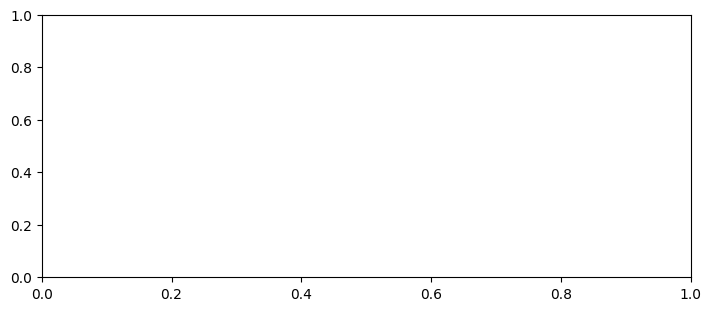

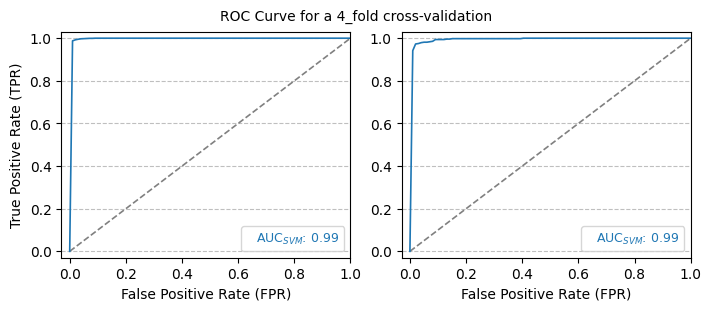

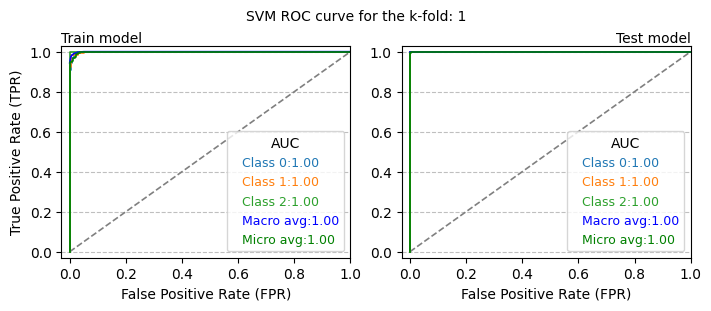

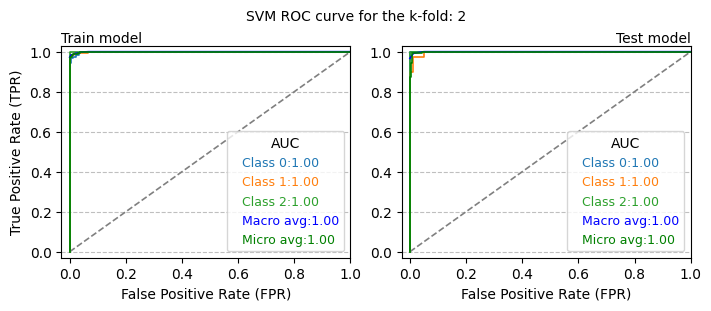

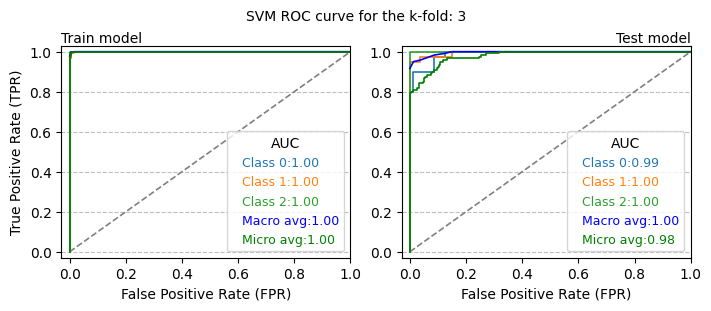

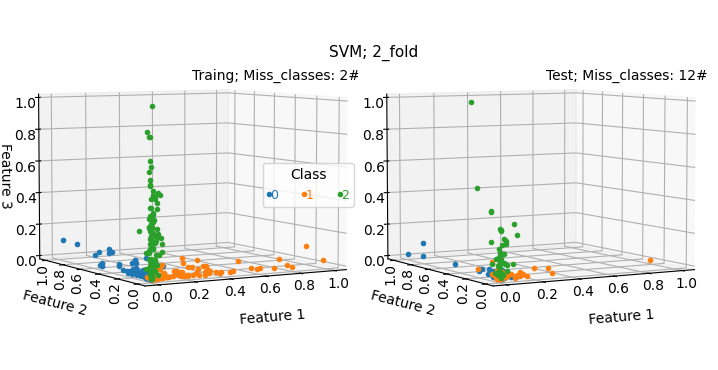

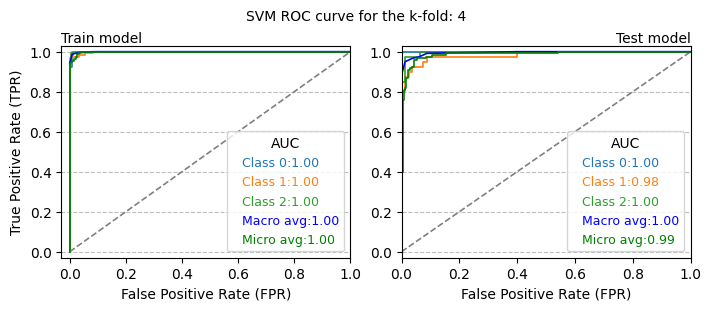

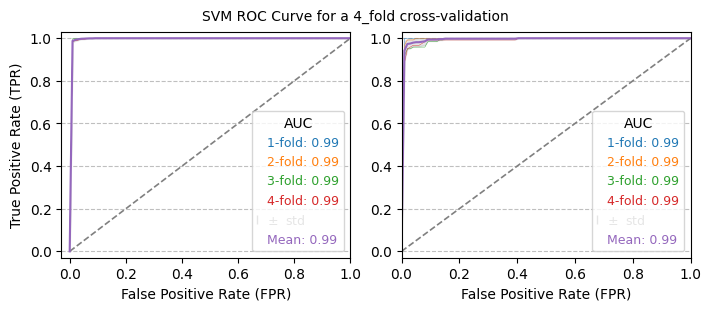

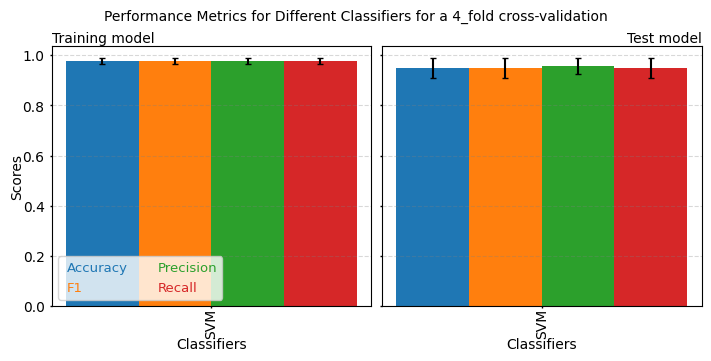

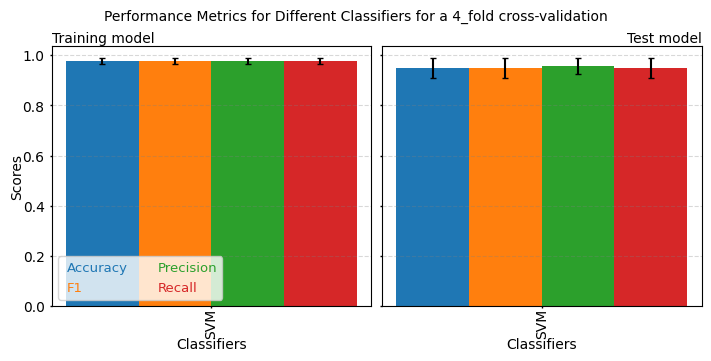

In [17]:
# ------------------------------------------------------ SVM --------------------------------------------
C_SVM = 100
criterion = "gini"                                  # gini, entropy, log_loss for DT and RF
kernel_SVM ="linear"                                # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'

k_fold = 4

method = "MinMaxScaler"                          # MinMaxScaler" , StandardScaler for data normalization 
normalize_active = "on"                          # normalize_active for data normalization

display_fold_classification = 2                  # Plot train and test data in k_fold eg., 1
display_classification = "on"                   # Display train and test data in k_fold eg., 1
display_normalize_classification ="on"          # Display train and test data is normalized

display_Roc_classes = "on"                      # Display Roc curve for all classes in each k-fold
display_all_kfold = "on"                        # Display Roc curve for each k-fold only
display_Roc_classification = "on"               # Display the average Roc curve of all k-folds for each classification

display_optimal_k = "on"                        # Display k optimal neighbors for KNN

display_performance_sessions = "off"
display_performance_all_sessions = "off"
fig_size_Roc = (7, 3)
fig_size_classification = (5, 3)
fig_size_performance = (7, 3.5) 

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 3), sharey="row", constrained_layout=True)

print("features = ",features.shape,end='\n\n')
print("labels = ",labels.shape)

trained_model = classification_methods(features, labels, k_fold, kernel_SVM, C_SVM, normalize_active, method, 
                       display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, 
                       display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, fig_size_performance, 
                       )


### Model Save

In [12]:
import joblib  # Import joblib for saving and loading models

model_save_path = r"/home/ubie/Desktop/Telekinesis/classify/Code/Python/trained_model.pkl"

joblib.dump(trained_model, model_save_path)
print(f"Model saved to {model_save_path}")



Model saved to /home/ubie/Desktop/Telekinesis/classify/Code/Python/trained_model.pkl


### Model Testing

In [15]:
def count_values(arr):
    """
    Function to count occurrences of 0s, 1s, and 2s in a given array.
    
    Parameters:
    arr (list): The input array containing numbers.
    
    Returns:
    tuple: A tuple containing the count of 0s, 1s, and 2s in the array.
    """
    count_zeros = np.count_nonzero(arr == 0)
    count_ones = np.count_nonzero(arr == 1)
    count_twos = np.count_nonzero(arr == 2)
        
    return count_zeros, count_ones, count_twos

print(features.shape)

saved_model = joblib.load("trained_model.pkl")

input_13 = features[:160,:]
input_21 = features[160:320,:]
input_17 = features[320:480,:]

feature_output = saved_model.predict(input_13)

z1,o1,t1 = count_values(feature_output)

print(f"predicted result = {feature_output}")

print(f"Result : Zeros: {z1}, Ones: {o1}, Twos: {t1}")

# mapping with commands

mapping = { 0 : "0", 1 : "1" , 2 : "2"}
print(mapping[ 0 if z1 > o1 and z1 > t1 else 1 if o1 > t1 else 2])


(480, 6)
predicted result = [1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0
 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0]
Result : Zeros: 125, Ones: 35, Twos: 0
0
